## Install and import dependencies

In [31]:
# NOTE: Make sure you install pytorch, torchvision etc. before running this script
!pip install -r requirements.txt

In [32]:
from transformers import AutoImageProcessor, AutoModelForImageClassification, Trainer, TrainingArguments
from datasets import load_dataset, load_metric
from torchvision.transforms import (
    Compose,
    Normalize,
    RandomHorizontalFlip,
    Resize,
    ToTensor,
)
import torch
import numpy as np

## Set some parameters
We might want to change those later so we define them on top of the file.

In [33]:
# model info: https://huggingface.co/microsoft/swin-tiny-patch4-window7-224
model_checkpoint = "microsoft/swin-tiny-patch4-window7-224"
batch_size = 8
out_dir = "./out"

## Load the data
We first load the dataset but only load a small split to reduce training time. Afterwards, we map labels and ids. If we pass this to the model later, it is initialized with the correct number of classes for our target dataset. 

Checkout https://huggingface.co/datasets

In [34]:
ds = load_dataset("beans")

train_ds = ds['train']
val_ds = ds['validation']


labels = train_ds.features["labels"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [35]:
print(train_ds)
print(val_ds)

Dataset({
    features: ['image_file_path', 'image', 'labels'],
    num_rows: 1034
})
Dataset({
    features: ['image_file_path', 'image', 'labels'],
    num_rows: 133
})


In [36]:
print(train_ds[0])

{'image_file_path': '/home/dritter/.cache/huggingface/datasets/downloads/extracted/e6e370ccc34a90a199d42625f3288f73bb696248e209f403d1578c360ed7b574/train/angular_leaf_spot/angular_leaf_spot_train.0.jpg', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x7FF56C88B0D0>, 'labels': 0}


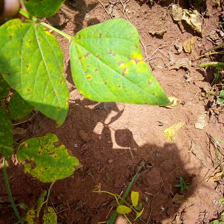

'angular_leaf_spot'

In [37]:
display(train_ds[0].get("image").resize((224, 224)))
id2label[str(train_ds[0].get("labels"))]

## Define image transforms and preprocessing functions

image_processor holds image specification info we can use to transform our images correctly.

In [38]:
image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (image_processor.size["height"], image_processor.size["width"])

train_transforms = Compose(
        [
            Resize(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [39]:
train_ds[0]

{'image_file_path': '/home/dritter/.cache/huggingface/datasets/downloads/extracted/e6e370ccc34a90a199d42625f3288f73bb696248e209f403d1578c360ed7b574/train/angular_leaf_spot/angular_leaf_spot_train.0.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500>,
 'labels': 0,
 'pixel_values': tensor([[[-1.1760, -1.1760, -1.1589,  ...,  0.0056,  0.4679, -0.4739],
          [-1.2617, -1.2445, -1.1932,  ..., -0.0116,  0.0227, -0.5082],
          [-1.3130, -1.3130, -1.2617,  ..., -0.4397, -0.7308, -0.4226],
          ...,
          [-1.1075, -1.1418, -1.2103,  ..., -0.1143, -0.0287, -0.1314],
          [-1.1589, -1.1932, -1.2103,  ...,  0.7419,  0.4679,  0.3481],
          [-1.2103, -1.2274, -1.2617,  ...,  0.6392,  0.4166,  0.5022]],
 
         [[-1.3880, -1.3880, -1.4755,  ..., -0.6352, -0.1625, -1.1429],
          [-1.4405, -1.4405, -1.4930,  ..., -0.6176, -0.5301, -1.0728],
          [-1.4755, -1.4755, -1.5280,  ..., -1.0028, -1.2654, -1.0028],
          ...,
          

## Define Training parameters 

Now we load the model and define our training arguments.

In [40]:

model = AutoModelForImageClassification.from_pretrained(model_checkpoint, label2id=label2id, id2label=id2label, ignore_mismatched_sizes=True)

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
train_args = TrainingArguments(
    output_dir='./out',
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    num_train_epochs=3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    remove_unused_columns=False
)


The collate function defines how batches of data are created.

In [42]:
# collate_fn to be used when batching data
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["labels"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

the compute_metrics function takes a Named Tuple as input: predictions, which are the logits of the model as Numpy arrays, and label_ids, which are the ground-truth labels as Numpy arrays.

In [43]:
metric = load_metric('accuracy')

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

## Start Training

Now create a Trainer instance and start training.

In [44]:
trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [45]:
# metrics = trainer.evaluate(val_ds)
# trainer.log_metrics("eval", metrics)

train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

metrics = trainer.evaluate(val_ds)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  eval_accuracy           =     0.3684
  eval_loss               =  7247736.0
  eval_runtime            = 0:00:01.13
  eval_samples_per_second =     116.75
  eval_steps_per_second   =     14.923


Epoch,Training Loss,Validation Loss,Accuracy
1,31679.250000,82466.609375,0.781955
2,42989.137500,67009.421875,0.977444
3,46426.693700,45948.507812,0.977444


Checkpoint destination directory ./out/checkpoint-130 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./out/checkpoint-260 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./out/checkpoint-390 already exists and is non-empty.Saving will proceed but saved results may be invalid.


***** train metrics *****
  epoch                    =         3.0
  total_flos               =  71810029GF
  train_loss               = 426733.3081
  train_runtime            =  0:00:44.97
  train_samples_per_second =      68.977
  train_steps_per_second   =       8.672


***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.9774
  eval_loss               = 67986.8281
  eval_runtime            = 0:00:00.94
  eval_samples_per_second =    141.192
  eval_steps_per_second   =     18.047
